In [1]:
library(igraph)
library(xts)
library(tools)
options(repr.plot.width=5, repr.plot.height=5)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [2]:
# Reading Time Series from file
# Date,Open,High,Low,Close,Volume,Adj Close

read_dframe = function(ticker){
    return( read.csv(paste("finance_data", "data", paste(ticker, "csv", sep="."), sep="/")) )
}
read_ts = function(ticker){
    df = read_dframe(ticker)
    
    if(is.element(ticker, c("BF.B", "BRK.B"))){
        return( xts(df[,-1], order.by = as.Date(df$Date, format="%m/%d/%y")) )
    }
    else{
        return( xts(df[,-1], order.by = as.Date(df$Date)))
    }
    
}

In [3]:
ts1 = read_ts("A")

In [4]:
ts2 = read_ts("L")

# 1. Calculating Correlations among Time Series Data:

In [5]:
# Return
r = function(ts){
    r1 = ts$Close
    r2 = lag(ts$Close, 1)
    return( tail(log(r1) - log(r2), -1) )
}

# Correlation
correlation = function(ts1, ts2){
    num = mean(r(ts1) * r(ts2)) - mean(r(ts1)) * mean(r(ts2))
    den1 = mean( r(ts1) ** 2 ) - ( mean( r(ts1)) ** 2 )
    den2 = mean( r(ts2) ** 2 ) - ( mean( r(ts2)) ** 2 )
    den = sqrt( den1 * den2 )
    
    return(num / den)
}

## Benefits of log returns:
[Link](http://www.dcfnerds.com/94/arithmetic-vs-logarithmic-rates-of-return/)

In [6]:
# List of Tickers
get.tickers = function(){
    unlist(lapply(list.files(paste("finance_data", "data", sep="/"), pattern="*.csv"), file_path_sans_ext))
}

In [7]:
tickers = get.tickers()

In [8]:
N = length(tickers)
N

[1] 505

In [9]:
# Cache the ticker data. Good luck if you don't!
ts = list()

for (ticker in tickers){
    ts[[ticker]] = read_ts(ticker)
}

# 2. Constructing Correlation Graphs:

In [10]:
if(!file.exists("correlation.dat")){
    M = matrix(0, nrow = N, ncol = N)

    for(u in (1  : N)){
        for(v in (1 : N)){
            tsu = ts[[tickers[u]]]
            tsv = ts[[tickers[v]]]
            M[u,v] = correlation(tsu, tsv)
        }
    }
    
    write.table(M, file="correlation.dat", row.names=FALSE, col.names=FALSE)
} else {
    M = data.matrix( unname( read.table("correlation.dat" ) ) )
}

In [11]:
D = sqrt( 2 * (1 - M) )

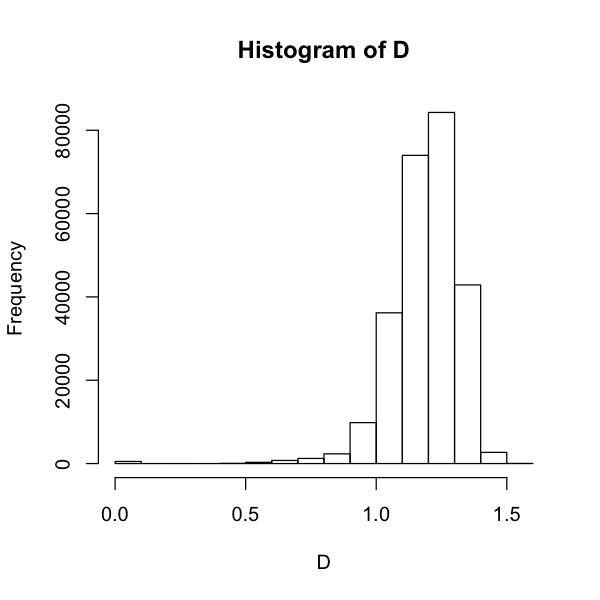

In [12]:
hist(D)

In [13]:
g = graph_from_adjacency_matrix(D, weighted=TRUE, mode="undirected")

In [14]:
V(g)$ticker = tickers

In [15]:
sector_map = new.env(hash = TRUE)

color_map = list(
    'Health Care' = 1,
    'Industrials' = 2,
    'Consumer Discretionary' = 3,
    'Information Technology' = 4,
    'Consumer Staples' = 5,
    'Utilities' = 6,
    'Financials' = 7,
    'Real Estate' = 8,
    'Materials' = 9,
    'Energy' = 10,
    'Telecommunication Services' = 11
)
for(line in readLines("finance_data/Name_sector.csv")){
    line = unlist(strsplit(line, ","))
    sector_map[[ line[1] ]] = color_map[[ line[2] ]]
}

colbar = rainbow(12)

In [16]:
gmst = mst(g, weights = E(g)$weight)

In [17]:
V(gmst)$name = tickers

In [18]:
V(gmst)$sector = unlist( lapply(V(gmst)$ticker, function(x){ sector_map[[ x ]] }) )

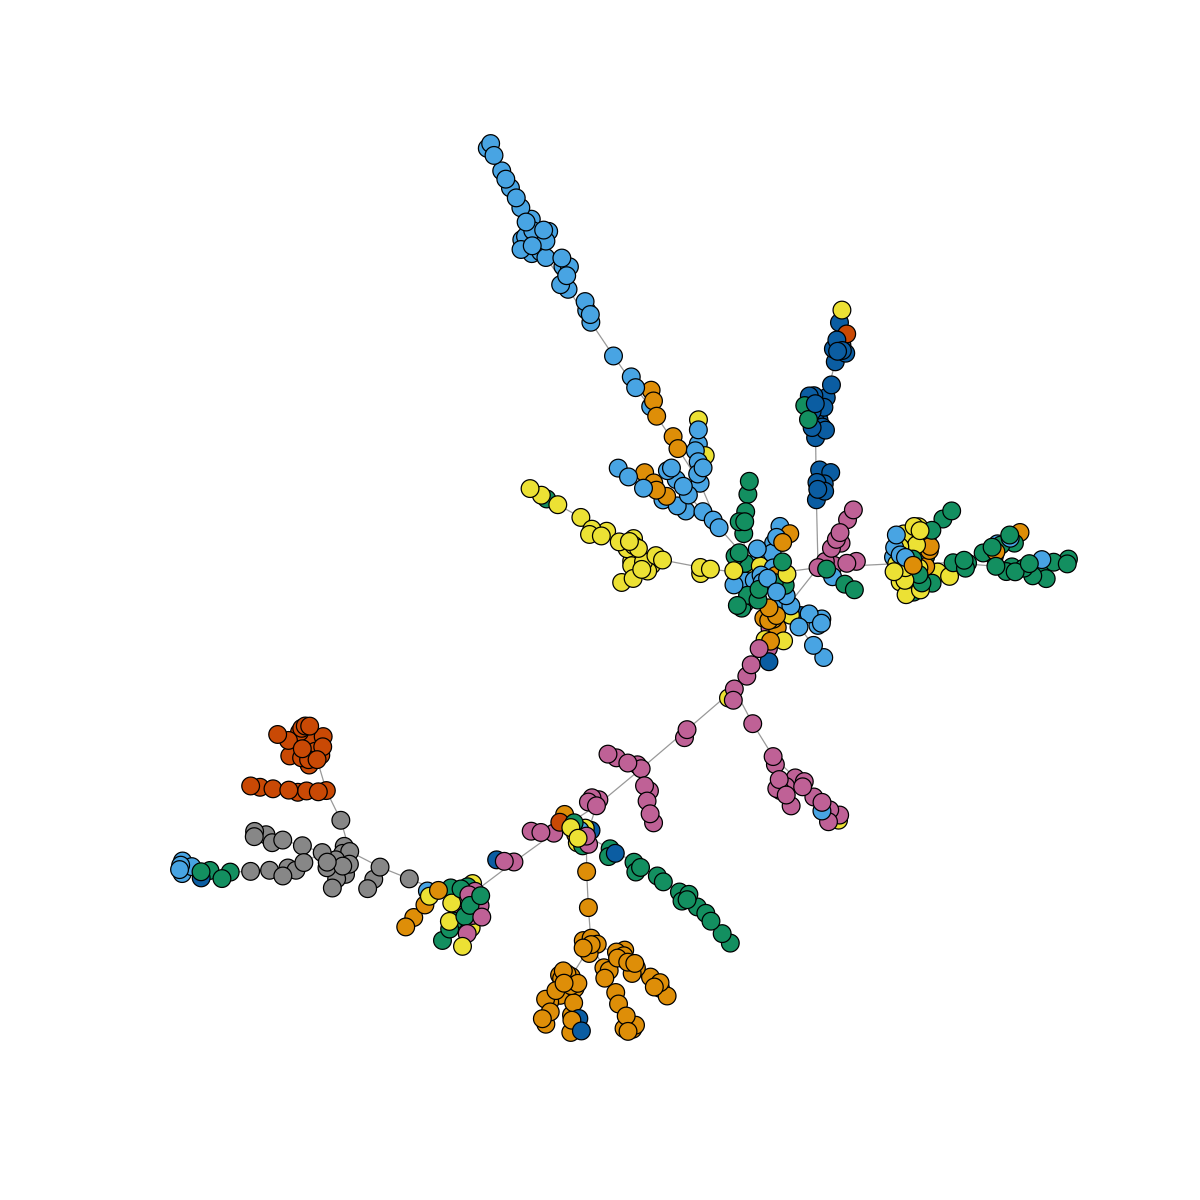

In [19]:
options(repr.plot.width=10, repr.plot.height=10)
plot(gmst, vertex.size = 4, vertex.color = V(gmst)$sector, edge.arrow.size=0, vertex.label=NA)

In [20]:
vertices = V(gmst)

p = function(vid){
    v = vertices[vid]
    vsec = v$sector
    nsecs = unlist( lapply(ego(gmst, 1, vid), function(x){ vertices[x]$sector }) )
    return( sum( vsec == nsecs ) / length(nsecs))
}


In [21]:
alpha = sum( unlist( lapply(1 : vcount(g), p) ) ) / vcount(g)

In [22]:
alpha

[1] 0.8941865

In [23]:
# Same thing with random 
sample_probs = unlist( table(V(gmst)$sector) / vcount(g), use.names = FALSE) 
V(gmst)$sector = sample(1 : 11, vcount(gmst), replace=TRUE, prob = sample_probs)
alpha = sum( unlist( lapply(1 : vcount(g), p) ) ) / vcount(g)
alpha

[1] 0.4785636

# Part 5

In [24]:
teq = function(eid){
    es = ends(g, eid)
    u = es[1]
    v = es[2]
    
    one_hop_neighs = intersect( ego(g, 1, u), ego(g, 1, v) )
    
    for(w in one_hop_neighs){
        if(D[u,v] > D[u,w] + D[w,v]){
            return(FALSE)
        }
    }
    
    return(TRUE)
}

In [25]:
# Triangle Equality
# for(i in 1 : ecount(g)){
#     if( !teq(i) ){
#         print(" FALSE ")
#         break;
#     }
# }
print(" TRUE ")

[1] " TRUE "


In [26]:
# Eulerian tour
tour = NULL
etour = function(u = 1){
    print(ecount(temp))
    adj = tail(unlist( ego(temp, 1, u) ), -1)
    for(v in adj){
        temp = delete.edges(temp, get.edge.ids(g, c(u, v)))
        find_etour(v)
    }
    tour = append(u, tour)
    
    find_etour(u)
    
    return(tour)
}

[TRAVELLING SALESMAN](http://www.geeksforgeeks.org/travelling-salesman-problem-set-2-approximate-using-mst/)

In [27]:
adj = function(g, u){
    return( tail( unlist( ego(g, 1, u) ), -1) )
}

In [28]:
# Basic approximation of TSP (2x in worst case)
sum(E(gmst)$weight) * 2

[1] 853.7965

In [29]:
###
# TRAVELLING SALESMAN PROBLEM
# Could't do the eulerian approximation. Did the preorder one instead
###

# 0. Make g directed
gd = graph_from_adjacency_matrix(D, weighted=TRUE)

# 1. Find minimum spanning tree
gmst = mst(gd, weights = E(gd)$weight)

In [30]:
# 2. Preorder traversal
preorder = function(g, u = 1, parent = 0){
    trail = c(parent, u)
    for(v in adj(g, u)){
        if(v != parent){
            trail = c(trail, preorder(g, v, u))
            trail = c(trail, c(v, u))
        }
    }
    
    return(trail)
}

porder = tail(preorder(gmst), -2)
length(porder)

[1] 2016

In [31]:
# 3. Remove repeated vertexes using short-cuts
trail = c()

i = 1
while(i <= length(porder)){
    u = porder[i]
    v = porder[i + 1]
    
    if(is.element(v, trail)){
        # get next edge
        i = i + 2
        v_new = porder[i+1]
        trail = c(trail, c(u, v_new))
    }
    else{
        trail = c(trail, c(u, v))
    }
    i = i + 2
}

length(trail)

[1] 1330

In [32]:
# 4. Better approximation (1.5x in worst case)
sum( E(g)[get.edge.ids(g, trail)]$weight )

[1] 612.4999

In [35]:
# Much better Solution (http://rpubs.com/somasdhavala/GAeg)
library(GA)

tourLength = function(tour, distMatrix) {
    tour = c(tour, tour[1])
    route = embed(tour, 2)[, 2:1]
    sum(distMatrix[route])
}

tpsFitness <- function(tour, ...){ 1/tourLength(tour, ...) }

GA.fit = ga(type = "permutation", fitness = tpsFitness, distMatrix = D, min = 1, 
    max = 505, popSize = 10, maxiter = 10000, run = 100, pmutation = 0.2, 
    monitor = NULL)

getAdj <- function(tour) {
    n <- length(tour)
    from <- tour[1:(n - 1)]
    to <- tour[2:n]
    m <- n - 1
    A <- matrix(0, m, m)
    A[cbind(from, to)] <- 1
    A <- A + t(A)
    return(A)
}

tourLength(GA.fit@solution[1,], D)

[1] 505.7986

# 6. Constructing Correlation Graphs for weekly data:

In [38]:
# Cache the ticker data. Good luck if you don't!
ts = list()

for (ticker in tickers){
    temp = read_ts(ticker)
    
    # Get only Monday Data
    ts[[ticker]] = temp[ weekdays(index(temp)) == 'Monday' ]
}

In [ ]:
if(!file.exists("correlation_monday.dat")){
    MM = matrix(0, nrow = N, ncol = N)

    for(u in (1  : N)){
        for(v in (1 : N)){
            tsu = ts[[tickers[u]]]
            tsv = ts[[tickers[v]]]
            MM[u,v] = correlation(tsu, tsv)
        }
    }
    
    write.table(M, file="correlation_monday.dat", row.names=FALSE, col.names=FALSE)
} else {
    MM = data.matrix( unname( read.table("correlation_monday.dat" ) ) )
}